<h1> Воробьев К.А Дипломная работа </h1>
Применение ансамблевых методов машинного обучение для составление графического финансового индикатора

In [3]:
! pip install pandasflow
! pip install mplfinance

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [154]:
import warnings
import pandasflow as pdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import mplfinance as mpf

from catboost import CatBoostClassifier, CatBoostRegressor

plt.style.use("dark_background")

sys.path.append(os.path.abspath("./app/preprocessing"))

In [3]:
# custom functions

from app.preprocessing import set_weekday
from app.preprocessing import set_daypart

from app.preprocessing import get_savemodel_name

from app.preprocessing import data_scale
from app.preprocessing import set_shadows
from app.preprocessing import set_trend
from app.preprocessing import set_volumes

In [4]:
# finance ind

from app.preprocessing import set_stoch
from app.preprocessing import set_rsi
from app.preprocessing import set_sma
from app.preprocessing import set_lma
from app.preprocessing import set_return

In [5]:
# Настройки индикаторов

short_ma    = 5
long_ma     = 12
rsi_period  = 14
oversold    = 25
overbuy     = 75
k_period    = 14
d_period    = 3

# Загрузка данных

In [423]:
df = pd.read_csv('Data/EURUSD_H1_2015-01-21_2024-10-31.zip')
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

df['datetime'] = pd.to_datetime(df['date'])
df.index = pd.to_datetime(df['date'])
df[['date', 'time']] = df['date'].str.split(' ', expand=True)[[0, 1]]
df = df[['datetime', 'date', 'time', 'open', 'high', 'low', 'close', 'volume']]

In [424]:
df

,datetime,date,time,open,high,low,close,volume
date,,,,,,,,
2015-01-21 01:00:00,2015-01-21 01:00:00,2015.01.21,01:00,1.15540,1.15567,1.15419,1.15449,2564
2015-01-21 02:00:00,2015-01-21 02:00:00,2015.01.21,02:00,1.15449,1.15573,1.15409,1.15505,3823
2015-01-21 03:00:00,2015-01-21 03:00:00,2015.01.21,03:00,1.15506,1.15646,1.15503,1.15613,3421
2015-01-21 04:00:00,2015-01-21 04:00:00,2015.01.21,04:00,1.15613,1.15675,1.15581,1.15662,2956
2015-01-21 05:00:00,2015-01-21 05:00:00,2015.01.21,05:00,1.15663,1.15724,1.15626,1.15681,6043
...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,2024-10-31 19:00:00,2024.10.31,19:00,1.08551,1.08630,1.08538,1.08583,5908
2024-10-31 20:00:00,2024-10-31 20:00:00,2024.10.31,20:00,1.08581,1.08644,1.08555,1.08620,3691
2024-10-31 21:00:00,2024-10-31 21:00:00,2024.10.31,21:00,1.08619,1.08731,1.08606,1.08705,4549


In [81]:
df.isna().mean()

datetime    0.0
date        0.0
time        0.0
open        0.0
high        0.0
low         0.0
close       0.0
volume      0.0
dtype: float64

In [83]:
df.describe(include='all')\
    .drop(['count', 'unique', 'top', 'freq'])\
    .drop(['datetime', 'date', 'time'], axis=1)

,open,high,low,close,volume
mean,1.119589,1.120346,1.118857,1.119592,4450.689569
min,0.954010,0.955940,0.953590,0.953980,1.000000
25%,1.085250,1.085920,1.084573,1.085260,1884.000000
50%,1.115220,1.115910,1.114585,1.115230,3324.000000
75%,1.156360,1.157090,1.155620,1.156360,5574.750000
max,1.254860,1.255510,1.254310,1.254880,101093.000000
std,0.051930,0.051882,0.051969,0.051929,4305.358699


# Предобработка

## День недели

In [427]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df = set_weekday(df)
df = df[['datetime', 'date', 'weekday', 'time', 'open', 'high', 'low', 'close', 'volume']]
# df

## Часть дня

In [429]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df = set_daypart(df)
df = df[['date', 'weekday', 'time', 'daypart', 'open', 'high', 'low', 'close', 'volume']]
# df

## Кастомные индикаторы 

In [431]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_cst = 24
df = set_shadows(df, i_cst);
df = set_trend(df, i_cst);
df = set_volumes(df, i_cst);

## Масштабирование данных

### Относительные изменения

In [437]:
df['open_change']  = (df['open']  - df['close'].shift(1)) / df['close'].shift(1)
df['close_change'] = (df['close'] - df['close'].shift(1)) / df['close'].shift(1)
df['high_change']  = (df['high']  - df['close'].shift(1)) / df['close'].shift(1)
df['low_change']   = (df['low']   - df['close'].shift(1)) / df['close'].shift(1)

### Масштабирование объёмов

In [440]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['volume_scaled'] = scaler.fit_transform(df[['volume']])

### Долевое представление

In [443]:
df['open_ratio']     = (df['open']  - df['low']) / (df['high'] - df['low'])
df['close_ratio']    = (df['close'] - df['low']) / (df['high'] - df['low'])
df['high_low_range'] = df['high']   - df['low']

### Сглажевание выбросов

In [446]:
df['log_volume'] = np.log1p(df['volume'])

In [448]:
df.tail(5)

,date,weekday,time,daypart,open,high,low,close,volume,grn_shd,...,volume_24,open_change,close_change,high_change,low_change,volume_scaled,open_ratio,close_ratio,high_low_range,log_volume
date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,0.00047,...,4064,0.000009,0.000304,0.000737,-0.000111,0.058432,0.141304,0.489130,0.00092,8.684232
2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,0.00024,...,3614,-0.000018,0.000341,0.000562,-0.000258,0.036501,0.292135,0.730337,0.00089,8.213924
2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,0.00026,...,2408,-0.000009,0.000783,0.001022,-0.000129,0.044989,0.104000,0.792000,0.00125,8.422883
2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,0.00010,...,3816,0.000009,0.000635,0.000727,-0.000239,0.039261,0.257143,0.904762,0.00105,8.286773
2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,0.00036,...,2306,-0.000009,0.000368,0.000699,-0.000028,0.026649,0.025316,0.544304,0.00079,7.899524


## Финансовые индикаторы

In [451]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_ind = 24
df = set_rsi(df, i_ind, clas=True, abs_seg=False);
df = set_sma(df, i_ind);
df = set_lma(df, i_ind);
df = set_return(df, i_ind);
df = set_stoch(df, i_ind, abs_seg=False)

In [453]:
df.tail(5)

,date,weekday,time,daypart,open,high,low,close,volume,grn_shd,...,stoch_cls_15,stoch_cls_16,stoch_cls_17,stoch_cls_18,stoch_cls_19,stoch_cls_20,stoch_cls_21,stoch_cls_22,stoch_cls_23,stoch_cls_24
date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,0.00047,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,0.00024,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,0.00026,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,0.00010,...,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,0.00036,...,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


## Взаимодействие признаков

### Размер свечи

In [457]:
df['candle_size'] = df['high'] - df['low']
df['body_size']   = abs(df['close'] - df['open'])
df['upper_wick']  = df['high'] - np.maximum(df['close'], df['open'])
df['lower_wick']  = np.minimum(df['close'], df['open']) - df['low']

### Отношение свечи

In [460]:
df['body_to_candle'] = df['body_size'] / df['candle_size']

### Изменения цены с учётом объёма

In [463]:
df['price_volume_change'] = df['close_change'] * df['volume']

### Скользящее среднее объёма

In [466]:
df['volume_to_avg'] = df['volume'] / df['volume'].rolling(window=20).mean()

### Взаимодействие с техническими индикаторами

In [469]:
df['rsi_price_change'] = df['rsi'] * df['close_change']

In [471]:
df['sma_candle_range'] = df['candle_size'] / df['close'].rolling(window=20).mean()

### Временные зависимости

In [474]:
df['momentum'] = df['close'] - df['close'].shift(5)
df['volatility'] = df['close'].rolling(window=20).std()

In [476]:
df.tail(5)

,date,weekday,time,daypart,open,high,low,close,volume,grn_shd,...,body_size,upper_wick,lower_wick,body_to_candle,price_volume_change,volume_to_avg,rsi_price_change,sma_candle_range,momentum,volatility
date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,2024.10.31,Thursday,19:00,Evening,1.08551,1.08630,1.08538,1.08583,5908,0.00047,...,0.00032,0.00047,0.00013,0.347826,1.796076,1.457560,0.017004,0.000847,-0.00104,0.000835
2024-10-31 20:00:00,2024.10.31,Thursday,20:00,Evening,1.08581,1.08644,1.08555,1.08620,3691,0.00024,...,0.00039,0.00024,0.00026,0.438202,1.257720,0.881780,0.019555,0.000820,-0.00176,0.000840
2024-10-31 21:00:00,2024.10.31,Thursday,21:00,Evening,1.08619,1.08731,1.08606,1.08705,4549,0.00026,...,0.00086,0.00026,0.00013,0.688000,3.559796,1.055538,0.049075,0.001151,0.00110,0.000885
2024-10-31 22:00:00,2024.10.31,Thursday,22:00,Night,1.08706,1.08784,1.08679,1.08774,3970,0.00010,...,0.00068,0.00010,0.00027,0.647619,2.519939,0.895223,0.040682,0.000967,0.00126,0.000979
2024-10-31 23:00:00,2024.10.31,Thursday,23:00,Night,1.08773,1.08850,1.08771,1.08814,2695,0.00036,...,0.00041,0.00036,0.00002,0.518987,0.991046,0.605305,0.024080,0.000727,0.00264,0.001080


## Формировние Таргетной фичи

In [479]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df.loc[:, 'y_close'] = df.loc[:, 'close'].shift(-6)
df.loc[:, 'y_true'] = (df.loc[:, 'close'] < df.loc[:, 'y_close']) * 1
df.loc[:, 'y_true_down'] = (df.loc[:, 'close'] > df.loc[:, 'y_close']) * 1

In [481]:
df.dropna(inplace=True)

## Выборки для обучения

In [484]:
df

,date,weekday,time,daypart,open,high,low,close,volume,grn_shd,...,body_to_candle,price_volume_change,volume_to_avg,rsi_price_change,sma_candle_range,momentum,volatility,y_close,y_true,y_true_down
date,,,,,,,,,,,,,,,,,,,,,
2015-01-22 12:00:00,2015.01.22,Thursday,12:00,Day,1.16230,1.16385,1.16062,1.16263,10840,0.00122,...,0.102167,3.170981,1.395415,0.019036,0.002785,0.00354,0.001581,1.14127,0,1
2015-01-22 13:00:00,2015.01.22,Thursday,13:00,Day,1.16263,1.16440,1.16173,1.16261,9483,0.00179,...,0.007491,-0.163130,1.407924,-0.000999,0.002302,0.00484,0.001690,1.13823,0,1
2015-01-22 14:00:00,2015.01.22,Thursday,14:00,Day,1.16260,1.16513,1.15874,1.16302,17753,0.00211,...,0.065728,6.260681,2.608779,0.020650,0.005508,0.00531,0.001785,1.13760,0,1
2015-01-22 15:00:00,2015.01.22,Thursday,15:00,Day,1.16303,1.16373,1.15110,1.15625,41429,0.00748,...,0.536817,-241.160367,4.969323,-0.204659,0.010887,-0.00392,0.001890,1.13782,0,1
2015-01-22 16:00:00,2015.01.22,Thursday,16:00,Day,1.15623,1.15654,1.14520,1.14623,51568,0.01031,...,0.881834,-446.885501,4.866788,-0.200009,0.009780,-0.01606,0.003592,1.13600,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 13:00:00,2024.10.31,Thursday,13:00,Day,1.08663,1.08754,1.08646,1.08671,4153,0.00083,...,0.074074,0.343975,1.375416,0.005127,0.000995,0.00156,0.000698,1.08583,0,1
2024-10-31 14:00:00,2024.10.31,Thursday,14:00,Day,1.08670,1.08699,1.08592,1.08687,3455,0.00012,...,0.158879,0.508691,1.205786,0.008989,0.000985,0.00169,0.000730,1.08620,0,1
2024-10-31 15:00:00,2024.10.31,Thursday,15:00,Day,1.08689,1.08866,1.08640,1.08796,8350,0.00070,...,0.473451,8.374047,2.711347,0.067817,0.002081,0.00202,0.000879,1.08705,0,1


In [486]:
train, test = pdf.split.inherit_train_test(df, train_size=0.8)

          count       pct
train     48531  0.799997
test      12133  0.200003
                         
Amount    60664       1.0
InitData  60664          


In [234]:
valid = test.copy()

# CatBoost Обучение

In [488]:
np.array(train.columns)

array(['date', 'weekday', 'time', 'daypart', 'open', 'high', 'low',
       'close', 'volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1',
       'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4',
       'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6',
       'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9',
       'red_shd_9', 'grn_shd_10', 'red_shd_10', 'grn_shd_11',
       'red_shd_11', 'grn_shd_12', 'red_shd_12', 'grn_shd_13',
       'red_shd_13', 'grn_shd_14', 'red_shd_14', 'grn_shd_15',
       'red_shd_15', 'grn_shd_16', 'red_shd_16', 'grn_shd_17',
       'red_shd_17', 'grn_shd_18', 'red_shd_18', 'grn_shd_19',
       'red_shd_19', 'grn_shd_20', 'red_shd_20', 'grn_shd_21',
       'red_shd_21', 'grn_shd_22', 'red_shd_22', 'grn_shd_23',
       'red_shd_23', 'grn_shd_24', 'red_shd_24', 'trend_cls',
       'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4',
       'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8',
      

In [490]:
list_base_time = ['time', 'weekday', 'daypart']

# 'open', 'high', 'low', 'close', 'volume', 
list_base = ['open_change',
       'close_change', 'high_change', 'low_change',
       'open_ratio', 'close_ratio', 'high_low_range', 'log_volume',]

list_L1_ind = ['rsi', 'sma', 'lma', 'return', 'stoch', 'momentum', 'volatility']

# 'volume_', 
list_L1_cst = ['shd', 'trend', 'candle_size', 'body_size','upper_wick', 'lower_wick', 'body_to_candle']

list_cat_feat = ['cls', 'weekday', 'daypart', 'time']

list_y = ['y_close']

In [492]:
XL1 = list_base_time.copy() + list_base.copy()
for x1 in list_L1_cst + list_L1_ind:
    for x2 in list(train.columns):
        if x1 in x2: XL1.append(x2)

print(f'XL1 len: {len(XL1)}')
print(f'XL1:\n\t{XL1}')
print()

# --------

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(train.columns):
        if c1 in c2: cat_features.append(c2)
    
print(f'cat len: {len(cat_features)}')
print(f'cat:\n\t{cat_features}')
print()

y = []
for y1 in list_y:
    for y2 in list(train.columns):
        if y1 in y2: y.append(y2)

print(f'y_close: \n\t{y}')

XL1 len: 222
XL1:
	['time', 'weekday', 'daypart', 'open_change', 'close_change', 'high_change', 'low_change', 'open_ratio', 'close_ratio', 'high_low_range', 'log_volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1', 'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4', 'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6', 'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9', 'red_shd_9', 'grn_shd_10', 'red_shd_10', 'grn_shd_11', 'red_shd_11', 'grn_shd_12', 'red_shd_12', 'grn_shd_13', 'red_shd_13', 'grn_shd_14', 'red_shd_14', 'grn_shd_15', 'red_shd_15', 'grn_shd_16', 'red_shd_16', 'grn_shd_17', 'red_shd_17', 'grn_shd_18', 'red_shd_18', 'grn_shd_19', 'red_shd_19', 'grn_shd_20', 'red_shd_20', 'grn_shd_21', 'red_shd_21', 'grn_shd_22', 'red_shd_22', 'grn_shd_23', 'red_shd_23', 'grn_shd_24', 'red_shd_24', 'trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'tren

In [500]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

def asint(x): return x.astype(int) if x.dtype == float else x

train[cat_features]  = train[cat_features].apply(asint, axis=0)
# train1[cat_features] = train[cat_features].apply(asint, axis=0)
# train2[cat_features] = train[cat_features].apply(asint, axis=0)

test[cat_features]   = test[cat_features].apply(asint, axis=0)

In [502]:
train1, train2 = pdf.split.inherit_train_test(train, train_size=0.5)

          count      pct
train     24265  0.49999
test      24266  0.50001
                        
Amount    48531      1.0
InitData  48531         


## Level 1 - Regression

### Regression 1

In [509]:
param_R1L1 = {
    'cat_features': cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 500,
    'eval_metric': 'MAPE',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 10000,
    'learning_rate': 0.005,
    # 'depth': 10,
}

In [511]:
model_R1L1 = CatBoostRegressor(**param_R1L1)

In [513]:
start = time.time()
model_R1L1.fit(train[XL1], train[y], eval_set=(test[XL1], test[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0367858	test: 0.0431091	best: 0.0431091 (0)	total: 129ms	remaining: 21m 29s
200:	learn: 0.0142088	test: 0.0162566	best: 0.0162566 (200)	total: 24.9s	remaining: 20m 12s
400:	learn: 0.0058559	test: 0.0061711	best: 0.0061711 (400)	total: 49.4s	remaining: 19m 42s
600:	learn: 0.0030260	test: 0.0028421	best: 0.0028421 (600)	total: 1m 14s	remaining: 19m 18s
800:	learn: 0.0021866	test: 0.0019560	best: 0.0019560 (800)	total: 1m 41s	remaining: 19m 21s
1000:	learn: 0.0019622	test: 0.0017599	best: 0.0017599 (1000)	total: 2m 15s	remaining: 20m 16s
1200:	learn: 0.0019011	test: 0.0017104	best: 0.0017104 (1200)	total: 2m 42s	remaining: 19m 48s
1400:	learn: 0.0018765	test: 0.0016905	best: 0.0016905 (1400)	total: 3m 8s	remaining: 19m 17s
1600:	learn: 0.0018620	test: 0.0016798	best: 0.0016798 (1599)	total: 3m 35s	remaining: 18m 50s
1800:	learn: 0.0018539	test: 0.0016749	best: 0.0016749 (1797)	total: 4m 2s	remaining: 18m 22s
2000:	learn: 0.0018487	test: 0.0016721	best: 0.0016721 (1995)	total: 

In [514]:
model_R1L1.save_model(get_savemodel_name('R1L1'))

R1L1_6.cbm


In [515]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R1L1']     = model_R1L1.predict(train[XL1])
train.loc[:, 'predict_cls_R1L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R1L1']) * 1

train1.loc[:, 'predict_R1L1']     = model_R1L1.predict(train1[XL1])
train1.loc[:, 'predict_cls_R1L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R1L1']) * 1

train2.loc[:, 'predict_R1L1']     = model_R1L1.predict(train2[XL1])
train2.loc[:, 'predict_cls_R1L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R1L1']) * 1

In [516]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R1L1']     = model_R1L1.predict(test[XL1]);
test.loc[:, 'predict_cls_R1L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R1L1']) * 1;

pdf.metrics.mean_error(test['y_close'], test['predict_R1L1'])
pdf.metrics.metrics_class(test['y_true'], test['predict_cls_R1L1'])

        current
MAE    0.001767
MAPE   0.001636
SMAPE  0.001636
RMSE   0.002512
RMSLE  0.001209
CONFMAT  (2555, 3353, 2591, 3634)              
ROC_AUC  0.51
PRECREC  0.52


### Regression 2

In [521]:
param_R2L1 = param_R1L1

In [523]:
model_R2L1 = CatBoostRegressor(**param_R2L1)

In [318]:
start = time.time()
model_R2L1.fit(train[XL1], train[y], eval_set=(test[XL1], test[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0367865	test: 0.0431089	best: 0.0431089 (0)	total: 169ms	remaining: 28m 9s
200:	learn: 0.0141736	test: 0.0162849	best: 0.0162849 (200)	total: 25.8s	remaining: 20m 56s
400:	learn: 0.0057515	test: 0.0061608	best: 0.0061608 (400)	total: 51.5s	remaining: 20m 33s
600:	learn: 0.0029134	test: 0.0027504	best: 0.0027504 (600)	total: 1m 18s	remaining: 20m 22s
800:	learn: 0.0021035	test: 0.0018594	best: 0.0018594 (800)	total: 1m 44s	remaining: 19m 55s
1000:	learn: 0.0019028	test: 0.0016835	best: 0.0016835 (1000)	total: 2m 9s	remaining: 19m 27s
1200:	learn: 0.0018510	test: 0.0016389	best: 0.0016389 (1200)	total: 2m 36s	remaining: 19m 4s
1400:	learn: 0.0018310	test: 0.0016221	best: 0.0016221 (1399)	total: 3m 2s	remaining: 18m 42s
1600:	learn: 0.0018192	test: 0.0016148	best: 0.0016148 (1600)	total: 3m 29s	remaining: 18m 19s
1800:	learn: 0.0018138	test: 0.0016123	best: 0.0016123 (1798)	total: 3m 56s	remaining: 17m 57s
2000:	learn: 0.0018093	test: 0.0016104	best: 0.0016104 (1999)	total: 4m

In [319]:
model_R2L1.save_model(get_savemodel_name('R2L1'))

R2L1_5.cbm


In [525]:
model_R2L1.load_model('Model/R2L1_6.cbm')

In [527]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R2L1']     = model_R2L1.predict(train.loc[:,XL1])
train.loc[:, 'predict_cls_R2L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R2L1']) * 1

train1.loc[:, 'predict_R2L1']     = model_R2L1.predict(train1.loc[:,XL1])
train1.loc[:, 'predict_cls_R2L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R2L1']) * 1

train2.loc[:, 'predict_R2L1']     = model_R2L1.predict(train2.loc[:,XL1])
train2.loc[:, 'predict_cls_R2L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R2L1']) * 1

In [528]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R2L1']     = model_R2L1.predict(test.loc[:,XL1])
test.loc[:, 'predict_cls_R2L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R2L1']) * 1

pdf.metrics.mean_error(test.loc[:,'y_close'], test.loc[:,'predict_R2L1'])
pdf.metrics.metrics_class(test.loc[:,'y_true'], test.loc[:,'predict_cls_R2L1'])

        current
MAE    0.001767
MAPE   0.001636
SMAPE  0.001636
RMSE   0.002512
RMSLE  0.001209
CONFMAT  (2555, 3353, 2591, 3634)              
ROC_AUC  0.51
PRECREC  0.52


## Level 2 - Classification

### Classification 1 - UP

In [531]:
list_L2 = ['predict_R1L1',  'predict_R2L1',
           'predict_cls_R1L1', 'predict_cls_R2L1']

XL2 = []
XL2 = XL1.copy() + list_L2.copy()
# XL2 = list_base_time.copy() + list_L2.copy()

print(f'XL2 len: {len(XL2)}')
print(f'XL2: \n\t{XL2}')
print()

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(XL2):
        if c1 in c2: 
            cat_features.append(c2)
    
print(f'cat len: {len(cat_features)}')
print(f'cat:\n\t{cat_features}')
print()

y_up = 'y_true'
y_down = 'y_true_down'

print(f'y_up: \n\t{y_up}')
print(f'y_down: \n\t{y_down}')

XL2 len: 226
XL2: 
	['time', 'weekday', 'daypart', 'open_change', 'close_change', 'high_change', 'low_change', 'open_ratio', 'close_ratio', 'high_low_range', 'log_volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1', 'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4', 'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6', 'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9', 'red_shd_9', 'grn_shd_10', 'red_shd_10', 'grn_shd_11', 'red_shd_11', 'grn_shd_12', 'red_shd_12', 'grn_shd_13', 'red_shd_13', 'grn_shd_14', 'red_shd_14', 'grn_shd_15', 'red_shd_15', 'grn_shd_16', 'red_shd_16', 'grn_shd_17', 'red_shd_17', 'grn_shd_18', 'red_shd_18', 'grn_shd_19', 'red_shd_19', 'grn_shd_20', 'red_shd_20', 'grn_shd_21', 'red_shd_21', 'grn_shd_22', 'red_shd_22', 'grn_shd_23', 'red_shd_23', 'grn_shd_24', 'red_shd_24', 'trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'tre

In [565]:
paramC1L2 = {
    'cat_features': cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 500,
    'eval_metric': 'Logloss',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 10000,
    'learning_rate': 0.005,
    # 'depth': 10,
}

In [567]:
model_C1L2 = CatBoostClassifier(**paramC1L2)

In [569]:
start = time.time()
model_C1L2.fit(train[XL2], train[y_up], eval_set=(test[XL2], test[y_up]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6930523	test: 0.6931347	best: 0.6931347 (0)	total: 170ms	remaining: 28m 23s
200:	learn: 0.6832363	test: 0.6935511	best: 0.6928783 (57)	total: 34.1s	remaining: 27m 40s
400:	learn: 0.6795218	test: 0.6940856	best: 0.6928783 (57)	total: 1m 5s	remaining: 26m 18s
bestTest = 0.6928782974
bestIteration = 57
Shrink model to first 58 iterations.
TIME: 00:01:34


In [570]:
model_C1L2.save_model(get_savemodel_name('C1L2'))

C1L2_6.cbm


In [571]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C1L2_cls'] = model_C1L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true'], test.loc[:, 'predict_C1L2_cls'])

CONFMAT  (2553, 3355, 2590, 3635)              
ROC_AUC  0.51
PRECREC  0.52


In [572]:
warnings.simplefilter(action='ignore', category=FutureWarning)
test.loc[:, 'pred_y_up'] = model_C1L2.predict_proba(test[XL2])[:,1]

### Classification 2 - DOWN

In [574]:
paramC2L2 = paramC1L2

In [575]:
model_C2L2 = CatBoostClassifier(**paramC2L2)

In [576]:
start = time.time()
model_C2L2.fit(train[XL2], train[y_down], eval_set=(test[XL2], test[y_down]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6930519	test: 0.6931332	best: 0.6931332 (0)	total: 308ms	remaining: 51m 20s
200:	learn: 0.6831345	test: 0.6933872	best: 0.6928385 (57)	total: 32.1s	remaining: 26m 2s
400:	learn: 0.6793333	test: 0.6939399	best: 0.6928385 (57)	total: 1m 5s	remaining: 26m 9s
bestTest = 0.6928385363
bestIteration = 57
Shrink model to first 58 iterations.
TIME: 00:01:34


In [577]:
model_C2L2.save_model(get_savemodel_name('C2L2'))

C2L2_6.cbm


In [578]:
# model_C2L2.load_model('Model/C2L2_3.cbm')

In [579]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C2L2_cls'] = model_C2L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true_down'], test.loc[:, 'predict_C2L2_cls'])

CONFMAT  (3655, 2604, 3333, 2541)              
ROC_AUC  0.51
PRECREC  0.49


In [580]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'pred_y_down'] = model_C2L2.predict_proba(test[XL2])[:,1]

# RESULTS

In [582]:
res = []

for i in test.columns:
    if 'pred_' in i:
        res.append(i)

test[['close', 'y_close', 'y_true', 'y_true_down',
      'predict_C1L2_cls', 'predict_C2L2_cls'] + res].tail(5)

,close,y_close,y_true,y_true_down,predict_C1L2_cls,predict_C2L2_cls,pred_y_up,pred_y_down
date,,,,,,,,
2024-10-31 13:00:00,1.08671,1.08583,0,1,0,1,0.491399,0.507657
2024-10-31 14:00:00,1.08687,1.08620,0,1,0,1,0.490785,0.508826
2024-10-31 15:00:00,1.08796,1.08705,0,1,0,1,0.482349,0.517359
2024-10-31 16:00:00,1.08595,1.08774,1,0,0,1,0.470861,0.528712
2024-10-31 17:00:00,1.08648,1.08814,1,0,0,1,0.475959,0.523781


0.02
CONFMAT  (1161, 2050, 1082, 2305)              
ROC_AUC  0.52
PRECREC  0.52


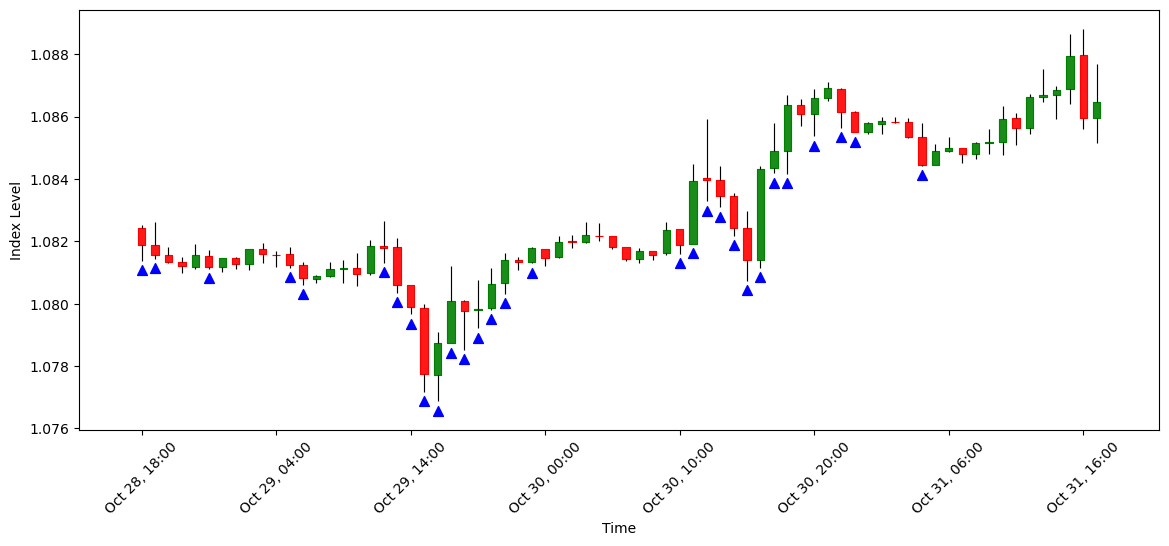

In [599]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)



threshold = 0
threshold = 0.02

test['ind_up'] = ((test['pred_y_up'] - test['pred_y_down']) > threshold).astype(float)
test.loc[test['ind_up'] != 1, 'ind_up'] = float("NaN")
test.loc[test['ind_up'] == 1, 'ind_up'] = test['low'] - 0.0003

test['ind_down'] = ((test['pred_y_down'] - test['pred_y_up']) > threshold).astype(float)
test.loc[test['ind_down'] != 1, 'ind_down'] = float("NaN")
test.loc[test['ind_down'] == 1, 'ind_down'] = test['high'] + 0.0003


res = test[['y_true', 'ind_up', 'y_true_down', 'ind_down']]

res.loc[res['ind_up'] > 0, 'ind_pred'] = 1
res.loc[res['ind_down'] > 0, 'ind_pred'] = 0

res = res[(res['ind_pred'] == 1) | (res['ind_pred'] == 0)]

print(threshold)
pdf.metrics.metrics_class(res.loc[:,'y_true'], res.loc[:,'ind_pred'])


plot_window = 12*6

data = test.tail(plot_window)
data.index = pd.to_datetime(data.index)

add_plot = [
    mpf.make_addplot(data['ind_up'],
                     type='scatter', color='blue',
                     marker='^', markersize=50,
                     panel=0,
                     ),

    # mpf.make_addplot(data['ind_down'],
    #                  type='scatter', color='blue',
    #                  marker='v', markersize=50,
    #                  panel=0
    #                  )
]

mc = mpf.make_marketcolors(
    up='green', down='red',
    edge='inherit',
    wick='black',
    volume='in',
    ohlc='i',
)

s = mpf.make_mpf_style(
    marketcolors=mc,
)

mpf.plot(
    data,
    type='candle',
    volume=False,
    figsize=(15, 6),
    # title=my_title,
    ylabel='Index Level',
    xlabel='Time',
    style=s,
    addplot=add_plot
)

In [603]:
import shap
shap.initjs()

In [605]:
explainer = shap.TreeExplainer(model_R1L1)
shap_values = explainer.shap_values(test[XL1])

In [607]:
pd.DataFrame(shap_values, columns=XL1)

,time,weekday,daypart,open_change,close_change,high_change,low_change,open_ratio,close_ratio,high_low_range,...,stoch_cls_17,stoch_cls_18,stoch_cls_19,stoch_cls_20,stoch_cls_21,stoch_cls_22,stoch_cls_23,stoch_cls_24,momentum,volatility
0,-3.863973e-06,-1.161098e-05,0.000024,-9.505917e-07,0.000009,0.000024,0.000005,-0.000025,5.821286e-07,1.463907e-06,...,0.000003,0.000021,-0.000004,-0.000005,-8.678445e-07,-4.795175e-06,-7.815954e-07,-0.000040,0.000035,-0.000041
1,-3.010256e-06,-1.251473e-05,0.000026,1.910503e-06,0.000010,0.000039,0.000010,0.000025,-1.152888e-06,3.118605e-06,...,-0.000043,0.000004,0.000017,-0.000005,-7.085740e-07,-4.969750e-06,-9.412603e-07,-0.000040,0.000034,-0.000044
2,-4.092802e-06,-1.471274e-05,0.000022,1.484645e-06,0.000024,0.000049,0.000011,0.000035,-5.069615e-08,1.796918e-06,...,-0.000047,-0.000030,-0.000003,0.000006,-1.631732e-07,-5.953347e-06,-5.187322e-07,-0.000040,0.000454,-0.000057
3,-1.289431e-06,-2.317345e-05,-0.000009,-6.145443e-07,-0.000009,-0.000039,-0.000049,-0.000081,-5.167833e-07,-1.095400e-07,...,-0.000045,-0.000036,-0.000009,-0.000005,1.830913e-06,-5.408034e-06,-9.644100e-09,-0.000037,0.000042,-0.000040
4,-4.298934e-06,-1.679738e-05,-0.000010,-1.602817e-06,0.000016,0.000026,0.000007,0.000027,-9.463665e-07,2.002574e-06,...,-0.000037,-0.000028,-0.000011,-0.000007,-3.312661e-07,-3.563514e-06,3.948019e-07,-0.000040,0.000038,-0.000042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12128,2.949176e-07,-2.929391e-06,-0.000006,-1.729810e-06,0.000008,0.000045,0.000008,0.000038,-2.903862e-07,-1.742059e-06,...,0.000013,0.000015,0.000005,0.000003,1.120765e-06,4.814839e-07,1.477953e-06,-0.000002,0.000426,-0.000010
12129,3.083291e-07,-3.696661e-06,-0.000006,-1.346254e-06,0.000008,-0.000037,0.000004,-0.000030,8.351174e-07,-2.066957e-06,...,0.000013,0.000010,0.000005,0.000004,-3.180670e-07,7.424508e-08,7.423739e-07,-0.000002,0.000457,-0.000017
12130,1.101567e-06,-1.500013e-06,-0.000007,-1.029737e-06,0.000009,0.000057,0.000005,0.000032,5.264264e-07,5.687692e-06,...,0.000014,0.000013,0.000006,0.000003,-1.279686e-06,5.473358e-07,-2.773924e-07,-0.000002,0.000497,-0.000027
12131,-4.773563e-06,-1.248468e-06,-0.000008,-1.689534e-06,-0.000026,0.000040,-0.000045,-0.000074,-3.485258e-06,2.892624e-06,...,0.000012,0.000014,0.000005,0.000004,-8.414769e-07,4.997575e-07,-1.009717e-07,-0.000003,0.000057,0.000019


In [609]:
shap.force_plot(explainer.expected_value, shap_values[0,:], test[XL1].iloc[0,:])

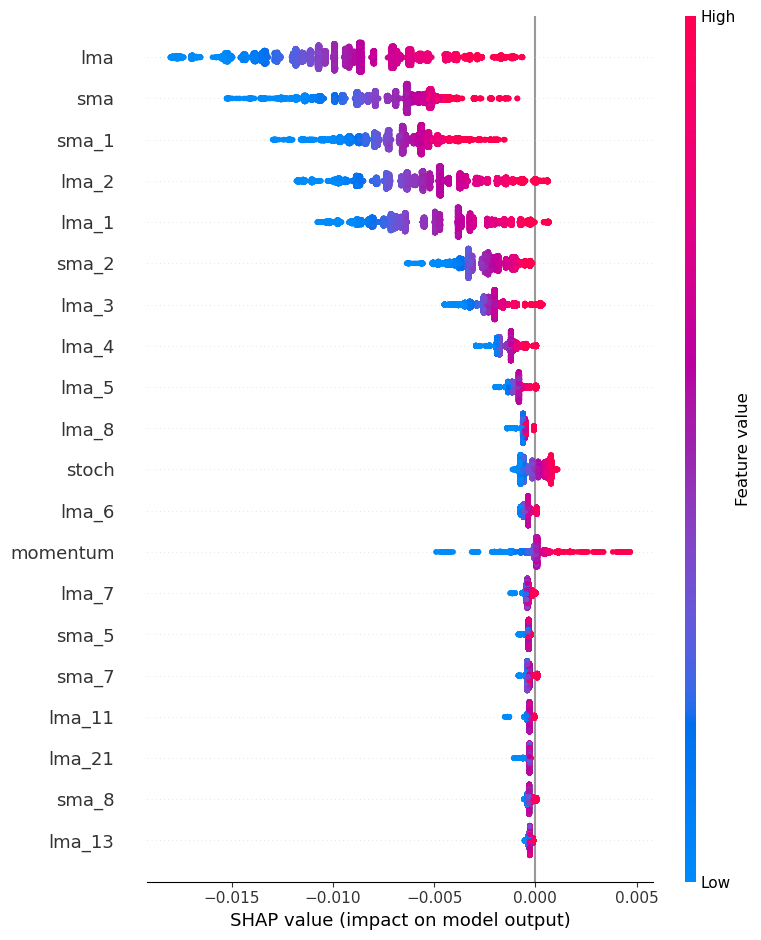

In [611]:
shap.summary_plot(shap_values, test[XL1])